In [8]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


In [9]:

# --- 1. Load Feature Names ---
# This step is needed to get the 'features' variable you used.
# We read the 2nd column (index 1) from features.txt.
try:
    features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
    feature_names = features_df[1].tolist()
except FileNotFoundError:
    print("Error: 'features.txt' not found. Make sure it's in the 'UCI HAR Dataset' folder.")
    # You would typically exit or handle this error, but for demonstration:
    feature_names = [] # Set to empty list to show the error

# --- 2. Load Training Data (X_train) ---
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)

# Set the column names
if feature_names:
    X_train.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: Feature names not loaded. Columns will be numbered.")

# --- 3. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None)[0]

# --- 4. Load Activity Labels (y_train) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_train_series = pd.read_csv('UCI HAR Dataset/train/y_train.txt', header=None, names=['Activity'])['Activity']

# --- 5. Combine All Data into One DataFrame ---
# It's good practice to copy X_train to avoid modifying the original
train = X_train.copy()

# Add the new columns
train['subject'] = subject_series
train['Activity'] = y_train_series

# --- 6. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

train['ActivityName'] = train['Activity'].map(activity_map)

# --- 7. Display a Sample ---
# Using .head() or .sample() is a great way to check your work
print("Data loaded successfully. Displaying first few data set:")
train.head(2)



C:\Users\new user\AppData\Local\Temp\ipykernel_28244\1967201394.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features_df = pd.read_csv('UCI HAR Dataset/features.txt', delim_whitespace=True, header=None)
C:\Users\new user\AppData\Local\Temp\ipykernel_28244\1967201394.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)


Data loaded successfully. Displaying first few data set:


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING


In [10]:
# --- 1. Load Test Data (X_test) ---
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)

# Set the column names
if 'feature_names' in locals():
    X_test.columns = feature_names # <-- Fixed: No extra brackets [ ]
else:
    print("Warning: 'feature_names' not found. Columns will be numbered.")

# --- 2. Load Subject Data ---
# FIX: Read the CSV, then select the first column (index 0) to get a Series.
subject_series_test = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header=None)[0]

# --- 3. Load Activity Labels (y_test) ---
# FIX: Read with a proper column name, then select that column to get a Series.
y_test_series = pd.read_csv('UCI HAR Dataset/test/y_test.txt', header=None, names=['Activity'])['Activity']

# --- 4. Combine All Data into One DataFrame ---
# Use .copy() to prevent SettingWithCopyWarning
test = X_test.copy()

# Add the new columns
test['subject'] = subject_series_test
test['Activity'] = y_test_series

# --- 5. Map Activity Names ---
# Your mapping code is perfect!
activity_map = {
    1: 'WALKING', 
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING', 
    5: 'STANDING',
    6: 'LAYING'
}

test['ActivityName'] = test['Activity'].map(activity_map)

# --- 6. Display a Sample ---
print("Test data loaded successfully. Displaying a random sample:")
print(test.head(2))


C:\Users\new user\AppData\Local\Temp\ipykernel_28244\2637941692.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)


Test data loaded successfully. Displaying a random sample:
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.257178          -0.023285          -0.014654         -0.938404   
1           0.286027          -0.013163          -0.119083         -0.975415   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.920091         -0.667683         -0.952501         -0.925249   
1         -0.967458         -0.944958         -0.986799         -0.968401   

   tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  angle(tBodyAccMean,gravity)  \
0         -0.674302         -0.894088  ...                     0.006462   
1         -0.945823         -0.894088  ...                    -0.083495   

   angle(tBodyAccJerkMean),gravityMean)  angle(tBodyGyroMean,gravityMean)  \
0                               0.16292                         -0.825886   
1                               0.01750                         -0.434375   

   angle(t

In [11]:
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


In [12]:
#Labels that are useful in plotting confusion matrix
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
#Let's make a function to plot the confusion matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))


    #  number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal numbre of cross validation sets: {}'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of best estimator : {}'.format(model.best_score_))

    

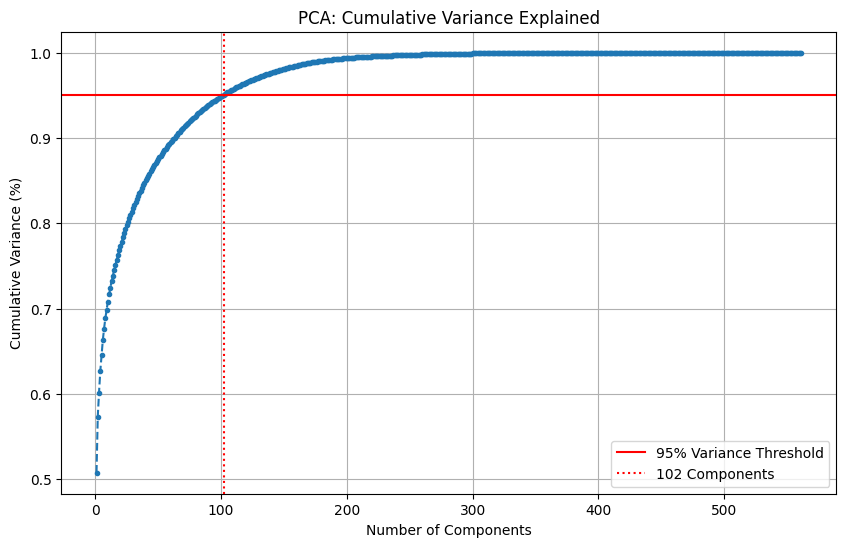

95% of variance is explained by the first 102 components.


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# 2. Fit PCA with ALL components
# We do this once to see how variance is distributed
pca_full = PCA()
pca_full.fit(X_scaled)

# 3. Calculate the cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# --- 4. Plot the "Scree Plot" ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--')

# --- Add the 95% line ---
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance Threshold')
# Find where 95% is crossed (this is the N components you found earlier)
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
plt.axvline(x=n_components_95, color='r', linestyle=':', label=f'{n_components_95} Components')

plt.title('PCA: Cumulative Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.legend()
plt.grid(True)
plt.show()

print(f"95% of variance is explained by the first {n_components_95} components.")

Running GridSearchCV for SVM without Dimensionality Reduction...
Training the SVM (No DR) model..
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Done....!

==> Training time:- 0:07:14.732872

Predicting test data
Done....!

==> Testing time:- 0:00:00.332465

==> Accuracy:- 0.9616559212758737


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  1 436  53   0   0   1]
 [  0  18 514   0   0   0]
 [  0   0   0 495   1   0]
 [  0   0   0   6 399  15]
 [  0   0   0  16   2 453]]


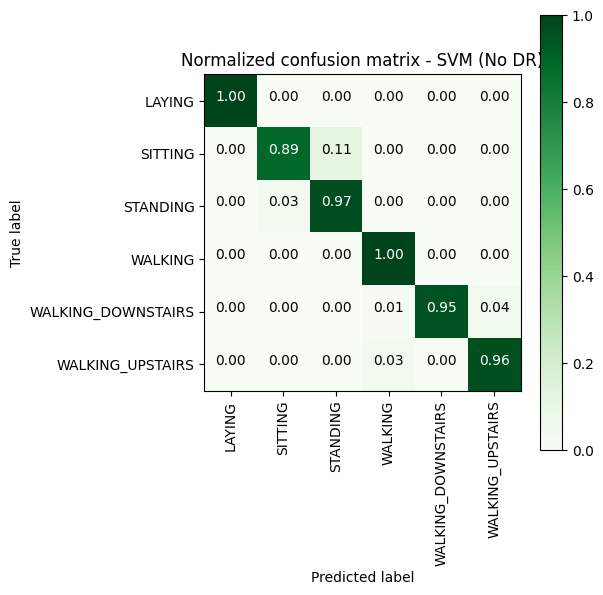

****************| Classification Report - SVM (No DR) |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.96      0.89      0.92       491
          STANDING       0.91      0.97      0.94       532
           WALKING       0.96      1.00      0.98       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.97      0.96      0.96       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('model', SVC(C=0.1, cache_size=500, kernel='linear'))])


==> Best parameters:
	Parameters of best estimator : {'model__C': 0.1, 'model__cache_size': 500, 'model__kernel': 'linear'}

==> No. of CrossValidation sets:
	Total numbre of cross 

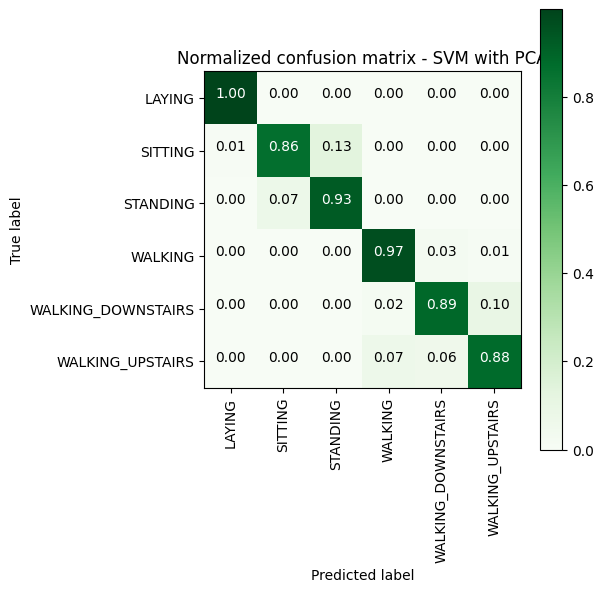

****************| Classification Report - SVM with PCA |****************
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       537
           SITTING       0.92      0.86      0.89       491
          STANDING       0.88      0.93      0.90       532
           WALKING       0.93      0.97      0.95       496
WALKING_DOWNSTAIRS       0.90      0.89      0.90       420
  WALKING_UPSTAIRS       0.90      0.88      0.89       471

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', PCA(n_components=0.95)),
                ('model', SVC(C=1, cache_size=500, kernel='linear'))])


==> Best parameters:
	Parameters of best estimator : {'model__C': 1, 'model__cache_size': 500, 'model__kernel': 'linear'}

==> No

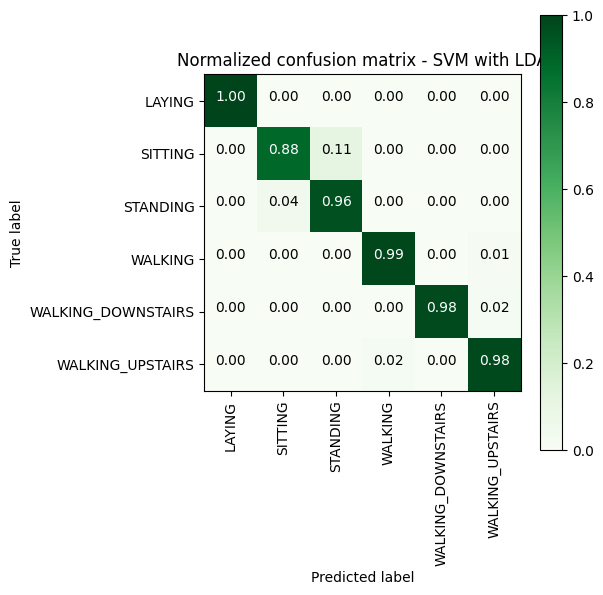

****************| Classification Report - SVM with LDA |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.95      0.88      0.92       491
          STANDING       0.90      0.96      0.93       532
           WALKING       0.98      0.99      0.98       496
WALKING_DOWNSTAIRS       1.00      0.98      0.99       420
  WALKING_UPSTAIRS       0.97      0.98      0.97       471

          accuracy                           0.97      2947
         macro avg       0.97      0.96      0.97      2947
      weighted avg       0.97      0.97      0.96      2947



==> Best Estimator:
	Pipeline(steps=[('scaler', StandardScaler()),
                ('dim_red', LinearDiscriminantAnalysis(n_components=5)),
                ('model', SVC(C=1, cache_size=500))])


==> Best parameters:
	Parameters of best estimator : {'model__C': 1, 'model__cache_size': 500, 'model__gamma': 'scale', 'model

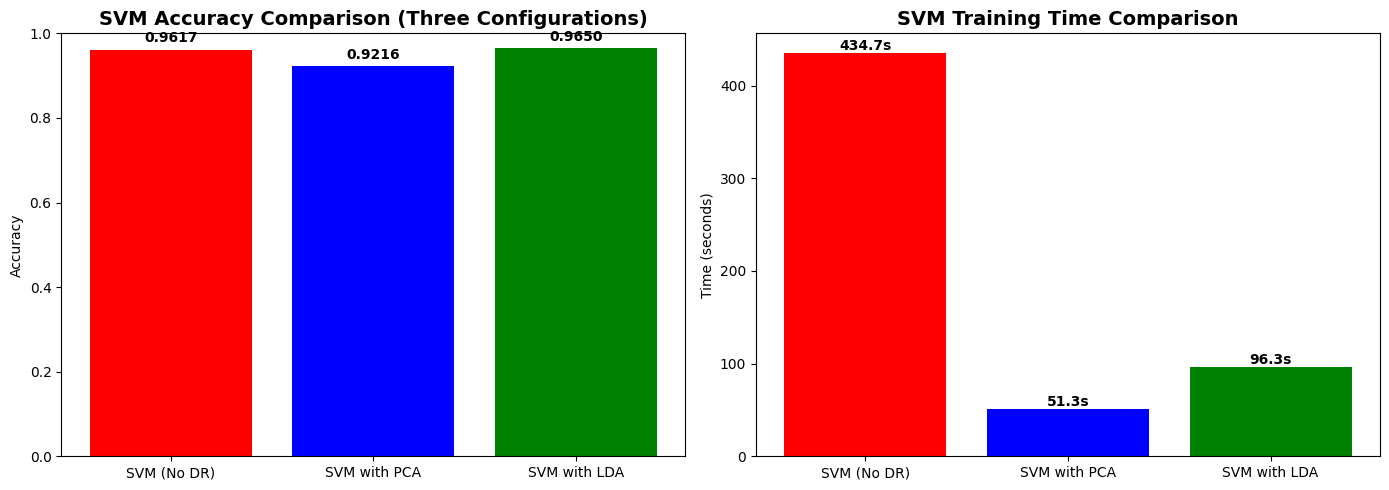


DETAILED THREE-WAY SVM COMPARISON
Model           | Accuracy | Training Time | Best Parameters
--------------------------------------------------------------------------------
SVM (No DR)     | 0.9617   | 434.7       s | kernel=linear, C=0.1
SVM + PCA       | 0.9216   | 51.3        s | kernel=linear, C=1
SVM + LDA       | 0.9650   | 96.3        s | kernel=rbf, C=1, gamma=scale

🏆 Best performing SVM model: SVM with LDA (Accuracy: 0.9650)

THREE-WAY CONFUSION MATRIX COMPARISON - SVM MODELS


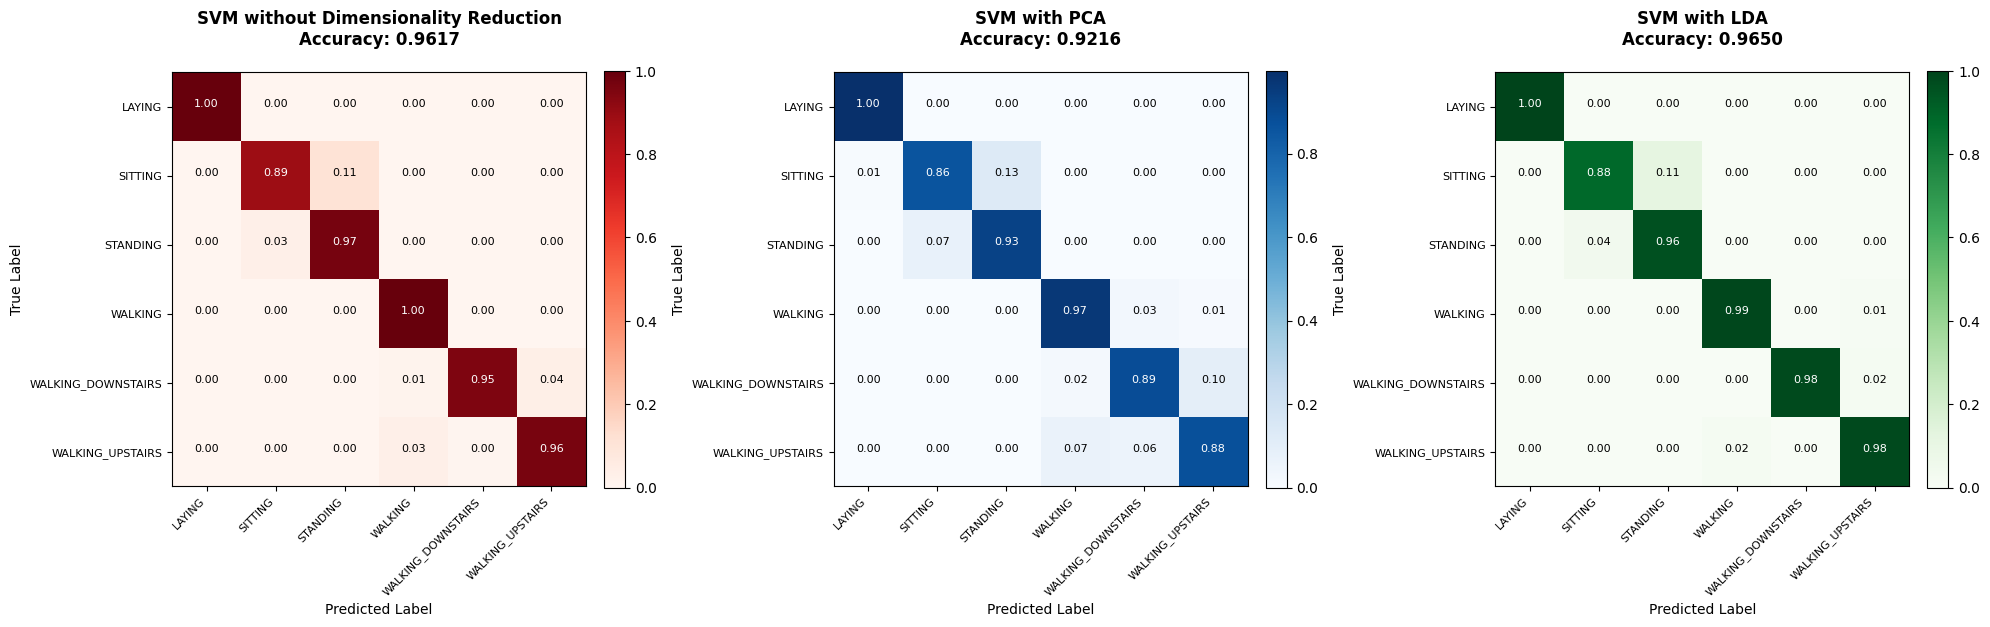


COMPREHENSIVE PERFORMANCE ANALYSIS
Performance improvements relative to SVM without dimensionality reduction:
  • SVM with PCA:  -0.0400 (-4.00%)
  • SVM with LDA:  +0.0034 (+0.34%)

Training efficiency:
  • Fastest model: SVM with PCA (51.3s)

FINAL COMPREHENSIVE RECOMMENDATION
🏆 STRONGLY RECOMMEND: SVM with Linear Discriminant Analysis (LDA)
   • Highest accuracy: 0.9650
   • Significant improvement over baseline: +0.34%
   • Comparable or faster training time


In [16]:
# Add this cell after your existing imports
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# --- SVM Implementation ---
def perform_svm_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, 
                     print_cm=True, cm_cmap=plt.cm.Greens, model_name="SVM"):
    """
    Perform SVM model training and evaluation
    """
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print(f'Training the {model_name} model..')
    model.fit(X_train, y_train)
    print('Done....!\n')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> Training time:- {}\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done....!\n')
    results['testing_time'] = test_end_time - test_start_time
    print('==> Testing time:- {}\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
   
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
        
    # plot confusion matrix
    plt.figure(figsize=(6,6))
    plt.grid(False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, 
                         title=f'Normalized confusion matrix - {model_name}', cmap=cm_cmap)
    plt.show()
    
    # get classification report
    print(f'****************| Classification Report - {model_name} |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
   
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    results['model_name'] = model_name
    
    return results

# Define SVM parameters for grid search
svm_parameters = [
    {
        'model__kernel': ['linear'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__cache_size': [500]
    },
    {
        'model__kernel': ['rbf'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'model__cache_size': [500]
    },
    {
        'model__kernel': ['poly'],
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__degree': [2, 3, 4],
        'model__gamma': ['scale', 'auto'],
        'model__cache_size': [500]
    }
]

# --- SVM without Dimensionality Reduction ---
print("Running GridSearchCV for SVM without Dimensionality Reduction...")

# Create simple SVM pipeline (just scaler + SVM)
simple_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC())
])

# Setup GridSearchCV for simple SVM
svm_grid_simple = GridSearchCV(
    simple_svm_pipeline,
    param_grid=svm_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run simple SVM model
svm_grid_simple_results = perform_svm_model(
    svm_grid_simple, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="SVM (No DR)"
)

print_grid_search_attributes(svm_grid_simple_results['model'])

# --- SVM with PCA ---
print("\nRunning GridSearchCV for PCA + SVM...")

# Create PCA pipeline for SVM
pca_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', PCA(n_components=0.95)),
    ('model', SVC())
])

# Setup GridSearchCV for SVM with PCA
svm_grid_pca = GridSearchCV(
    pca_svm_pipeline,
    param_grid=svm_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run SVM model with PCA
svm_grid_pca_results = perform_svm_model(
    svm_grid_pca, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="SVM with PCA"
)

print_grid_search_attributes(svm_grid_pca_results['model'])

# --- SVM with LDA ---
print("\nRunning GridSearchCV for LDA + SVM...")

# Create LDA pipeline for SVM
lda_svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_red', LDA(n_components=5)),  # LDA for dimensionality reduction
    ('model', SVC())
])

# Setup GridSearchCV for LDA + SVM
svm_grid_lda = GridSearchCV(
    lda_svm_pipeline,
    param_grid=svm_parameters,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Run LDA + SVM model
svm_grid_lda_results = perform_svm_model(
    svm_grid_lda, 
    X_train, y_train, X_test, y_test, 
    class_labels=labels,
    model_name="SVM with LDA"
)

print_grid_search_attributes(svm_grid_lda_results['model'])

# --- Three-Way SVM Comparison ---
print("\n" + "="*60)
print("THREE-WAY SVM MODEL COMPARISON")
print("="*60)
print(f"SVM without DR:  {svm_grid_simple_results['accuracy']:.4f}")
print(f"SVM with PCA:    {svm_grid_pca_results['accuracy']:.4f}")
print(f"SVM with LDA:    {svm_grid_lda_results['accuracy']:.4f}")

# Extract best parameters for comparison
simple_best_params = svm_grid_simple_results['model'].best_params_
pca_best_params = svm_grid_pca_results['model'].best_params_
lda_best_params = svm_grid_lda_results['model'].best_params_

print("\nBest Parameters:")
print(f"SVM without DR: {simple_best_params}")
print(f"PCA + SVM:      {pca_best_params}")
print(f"LDA + SVM:      {lda_best_params}")

# --- Three-Way SVM Comparison Visualization ---
svm_models = ['SVM (No DR)', 'SVM with PCA', 'SVM with LDA']
svm_accuracies = [
    svm_grid_simple_results['accuracy'],
    svm_grid_pca_results['accuracy'],
    svm_grid_lda_results['accuracy']
]

svm_training_times = [
    svm_grid_simple_results['training_time'].total_seconds(),
    svm_grid_pca_results['training_time'].total_seconds(),
    svm_grid_lda_results['training_time'].total_seconds()
]

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = ['red', 'blue', 'green']
bars1 = ax1.bar(svm_models, svm_accuracies, color=colors)
ax1.set_title('SVM Accuracy Comparison (Three Configurations)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for bar, acc in zip(bars1, svm_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Training time comparison  
bars2 = ax2.bar(svm_models, svm_training_times, color=colors)
ax2.set_title('SVM Training Time Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Time (seconds)')
for bar, time in zip(bars2, svm_training_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed comparison
print("\n" + "="*80)
print("DETAILED THREE-WAY SVM COMPARISON")
print("="*80)
print(f"{'Model':<15} | {'Accuracy':<8} | {'Training Time':<12} | Best Parameters")
print("-" * 80)

simple_params_str = f"kernel={simple_best_params['model__kernel']}, C={simple_best_params['model__C']}"
pca_params_str = f"kernel={pca_best_params['model__kernel']}, C={pca_best_params['model__C']}"
lda_params_str = f"kernel={lda_best_params['model__kernel']}, C={lda_best_params['model__C']}"

# Add gamma if present in best parameters
if 'model__gamma' in simple_best_params:
    simple_params_str += f", gamma={simple_best_params['model__gamma']}"
if 'model__gamma' in pca_best_params:
    pca_params_str += f", gamma={pca_best_params['model__gamma']}"
if 'model__gamma' in lda_best_params:
    lda_params_str += f", gamma={lda_best_params['model__gamma']}"

print(f"{'SVM (No DR)':<15} | {svm_accuracies[0]:<8.4f} | {svm_training_times[0]:<12.1f}s | {simple_params_str}")
print(f"{'SVM + PCA':<15} | {svm_accuracies[1]:<8.4f} | {svm_training_times[1]:<12.1f}s | {pca_params_str}")
print(f"{'SVM + LDA':<15} | {svm_accuracies[2]:<8.4f} | {svm_training_times[2]:<12.1f}s | {lda_params_str}")

# Determine winner
best_accuracy = max(svm_accuracies)
best_model_index = svm_accuracies.index(best_accuracy)
winner = svm_models[best_model_index]

print(f"\n🏆 Best performing SVM model: {winner} (Accuracy: {best_accuracy:.4f})")
print("="*80)

# --- Three-Way Confusion Matrix Comparison ---
print("\n" + "="*80)
print("THREE-WAY CONFUSION MATRIX COMPARISON - SVM MODELS")
print("="*80)

# Get confusion matrices
cm_simple = svm_grid_simple_results['confusion_matrix']
cm_pca = svm_grid_pca_results['confusion_matrix']
cm_lda = svm_grid_lda_results['confusion_matrix']

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Normalize confusion matrices
cm_simple_normalized = cm_simple.astype('float') / cm_simple.sum(axis=1)[:, np.newaxis]
cm_pca_normalized = cm_pca.astype('float') / cm_pca.sum(axis=1)[:, np.newaxis]
cm_lda_normalized = cm_lda.astype('float') / cm_lda.sum(axis=1)[:, np.newaxis]

# Plot Simple SVM Confusion Matrix
im1 = ax1.imshow(cm_simple_normalized, interpolation='nearest', cmap=plt.cm.Reds)
ax1.set_title('SVM without Dimensionality Reduction\nAccuracy: {:.4f}'.format(svm_grid_simple_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax1.set_xlabel('Predicted Label', fontsize=10)
ax1.set_ylabel('True Label', fontsize=10)
tick_marks = np.arange(len(labels))
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax1.set_yticklabels(labels, fontsize=8)

# Plot PCA SVM Confusion Matrix
im2 = ax2.imshow(cm_pca_normalized, interpolation='nearest', cmap=plt.cm.Blues)
ax2.set_title('SVM with PCA\nAccuracy: {:.4f}'.format(svm_grid_pca_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax2.set_xlabel('Predicted Label', fontsize=10)
ax2.set_ylabel('True Label', fontsize=10)
ax2.set_xticks(tick_marks)
ax2.set_yticks(tick_marks)
ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax2.set_yticklabels(labels, fontsize=8)

# Plot LDA SVM Confusion Matrix
im3 = ax3.imshow(cm_lda_normalized, interpolation='nearest', cmap=plt.cm.Greens)
ax3.set_title('SVM with LDA\nAccuracy: {:.4f}'.format(svm_grid_lda_results['accuracy']), 
              fontsize=12, fontweight='bold', pad=20)
ax3.set_xlabel('Predicted Label', fontsize=10)
ax3.set_ylabel('True Label', fontsize=10)
ax3.set_xticks(tick_marks)
ax3.set_yticks(tick_marks)
ax3.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax3.set_yticklabels(labels, fontsize=8)

# Add text annotations for all matrices
for ax, cm_norm in zip([ax1, ax2, ax3], [cm_simple_normalized, cm_pca_normalized, cm_lda_normalized]):
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black",
                 fontsize=8)

# Add colorbars
plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- Comprehensive Performance Analysis ---
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE ANALYSIS")
print("="*80)

# Calculate improvements relative to baseline (no DR)
baseline_accuracy = svm_grid_simple_results['accuracy']
pca_improvement = svm_grid_pca_results['accuracy'] - baseline_accuracy
lda_improvement = svm_grid_lda_results['accuracy'] - baseline_accuracy

print(f"Performance improvements relative to SVM without dimensionality reduction:")
print(f"  • SVM with PCA:  {pca_improvement:+.4f} ({pca_improvement*100:+.2f}%)")
print(f"  • SVM with LDA:  {lda_improvement:+.4f} ({lda_improvement*100:+.2f}%)")

# Training time comparison
fastest_time = min(svm_training_times)
fastest_model_index = svm_training_times.index(fastest_time)
fastest_model = svm_models[fastest_model_index]

print(f"\nTraining efficiency:")
print(f"  • Fastest model: {fastest_model} ({fastest_time:.1f}s)")

# Final comprehensive recommendation
print("\n" + "="*80)
print("FINAL COMPREHENSIVE RECOMMENDATION")
print("="*80)

if lda_improvement > 0 and svm_grid_lda_results['accuracy'] == best_accuracy:
    print("🏆 STRONGLY RECOMMEND: SVM with Linear Discriminant Analysis (LDA)")
    print(f"   • Highest accuracy: {svm_grid_lda_results['accuracy']:.4f}")
    print(f"   • Significant improvement over baseline: {lda_improvement*100:+.2f}%")
    if svm_training_times[2] <= svm_training_times[0]:
        print(f"   • Comparable or faster training time")
elif pca_improvement > 0 and svm_grid_pca_results['accuracy'] == best_accuracy:
    print("🏆 RECOMMEND: SVM with Principal Component Analysis (PCA)")
    print(f"   • Good accuracy: {svm_grid_pca_results['accuracy']:.4f}")
    print(f"   • Moderate improvement over baseline: {pca_improvement*100:+.2f}%")
else:
    print("🏆 CONSIDER: SVM without Dimensionality Reduction")
    print(f"   • Simpler implementation")
    print(f"   • No additional preprocessing steps required")

print("="*80)

